## Incorporating the Reimannian metric A in optimization
Requires an optimization method that can take a Hessian or a Hessian-Product as input.

[SciPy Optimize Reference](http://docs.scipy.org/doc/scipy-0.14.0/reference/tutorial/optimize.html)

In [13]:
import numpy as np
import scipy.optimize

In [14]:
def unflat(x, ndim, xs, xt):
    xall = x.reshape(x.shape[0]/ndim,ndim)
    return np.vstack((xs, xall, xt))

def flat(x):
    return x.flatten()

def optimize(xs, xt, x0=None):
    '''
    Functional gradient optimization
    @param x0 - inital seed for waypoints
    @param xs - fixed start configuration
    @param xt - fixed target configuration
    @return res - SciPy dict of optimization result
    @return xall - (numIter x waypoints) iterations
    '''
    ndim = xs.shape[0]
    if x0 is None:
        npts = 10
        x0 = np.random.rand(npts, ndim)
    npts = x0.shape[0]
    hess = np.diag([2]*npts*ndim)
    rows = np.arange(0, npts*ndim-ndim)
    cols = np.arange(ndim, npts*ndim)
    hess[rows, cols] = -1
    hess[cols, rows] = -1
    def fn(x):
        traj = unflat(x, ndim, xs, xt)
        return 0.5*np.sum([np.linalg.norm(traj[i,:] - traj[i-1,:])**2 for i in range(1, npts+2)])
    def jac(x):
        traj = unflat(x, ndim, xs, xt)
        grad = 2*traj[1:-1,:] - traj[2:,:] - traj[0:-2,:]
        return flat(grad)
    def hessian(x):
        return hess
    xall = []
    def fn_call(x):
        xall.append(x)    
    res = scipy.optimize.minimize(fn, flat(x0), method='Newton-CG', jac=jac, hess=hessian, callback=fn_call)
    return res, np.asarray(xall)

In [15]:
def animate_traj(xall, fname='traj.mp4'):
    fig = plt.figure()
    def update(i):
        traj = unflat(xall[i, :], ndim, xs, xt)
        plt.cla()
        plt.axis([-0.2, 1.2, -0.2, 1.2])
        return plt.plot(traj[:, 0], traj[:, 1], 'ro-')
    ani = animation.FuncAnimation(fig, update, frames=range(xall.shape[0]))
    ani.save(fname)
    return ani

In [18]:
ndim = 2
npts = 10
xs = np.zeros(ndim)
xt = np.ones(ndim)
res, xall = optimize(xs, xt, x0=None)
print res['message']
print 'Evals:', res['njev'], '+', res['nfev'], '+', res['nhev'], '=', res['njev'] + res['nfev'] + res['nhev']

Optimization terminated successfully. : 18 + 10 + 9 = 37


[-0.2, 1.2, -0.2, 1.2]

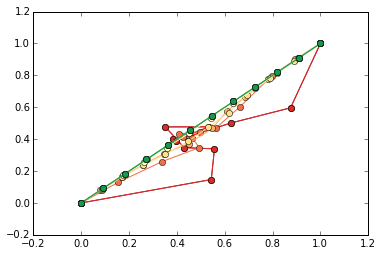

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm
numplot = 10.
mycm = cm.RdYlGn
for j, i in enumerate(np.linspace(0, xall.shape[0]-1, numplot, dtype=np.int64)):
    traj = unflat(xall[i, :], ndim, xs, xt)
    im = plt.plot(traj[:, 0], traj[:, 1], 'o-', color=mycm(j/numplot))
plt.axis([-0.2, 1.2, -0.2, 1.2])

In [ ]:
ani = animate_traj(xall)